<a href="https://colab.research.google.com/github/daoudecho/Introduction-to-TensorFlow/blob/master/Chest_X_Ray_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
!pip install kaggle

In [38]:


from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [39]:
!kaggle datasets list

ref                                                       title                                              size  lastUpdated          downloadCount  
--------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
therohk/ireland-historical-news                           The Irish Times - Waxy-Wany News                   47MB  2019-08-24 15:36:54           1179  
dgomonov/new-york-city-airbnb-open-data                   New York City Airbnb Open Data                      2MB  2019-08-12 16:24:45          12356  
lakshyaag/india-trade-data                                India - Trade Data                                  1MB  2019-08-16 16:13:58           6992  
bradklassen/pga-tour-20102018-data                        PGA Tour Golf Data                                 94MB  2019-08-30 00:09:59           5527  
r3w0p4/bournemouth-venues                                 Venues in Bournemouth         

In [40]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content 

100% 1.15G/1.15G [00:07<00:00, 171MB/s]
100% 1.15G/1.15G [00:07<00:00, 157MB/s]


In [41]:
import os
!apt install pv
!unzip -o /content/chest-xray-pneumonia.zip  | pv -l >/dev/null
os.remove('chest-xray-pneumonia.zip')
!unzip -o /content/chest_xray.zip  | pv -l >/dev/null
os.remove('chest_xray.zip')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pv is already the newest version (1.6.6-1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
2.00  0:00:28 [71.1m/s] [  <=>                                                 ]
11.7k 0:00:40 [ 292 /s] [                                        <=>           ]


In [0]:
# Path to data
data_dir  = '/content/chest_xray/'
train_dir = data_dir+'train/'
test_dir  = data_dir+'test/'
val_dir   = data_dir + 'val/'

In [43]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir + 'NORMAL/'
pneumonia_cases_dir = train_dir + 'PNEUMONIA/'

print("Datasets:\t",os.listdir(data_dir))
print("Train:\t", os.listdir(train_dir))
print("Test:\t", os.listdir(test_dir))

Datasets:	 ['val', '.DS_Store', 'test', 'train']
Train:	 ['.DS_Store', 'NORMAL', 'PNEUMONIA']
Test:	 ['.DS_Store', 'NORMAL', 'PNEUMONIA']


In [44]:
print(len(data_dir))
print(len(train_dir))
print(len(test_dir))
print(len(val_dir))

20
26
25
24


In [0]:
import tensorflow as tf
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

## Specify the values for all arguments to data_generator_with_aug.
data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                            
                                             horizontal_flip = True,
                                             width_shift_range = 0.2,
                                             height_shift_range = 0.2,
                                             shear_range = 0.2,
                                             zoom_range = 0.2
                                            )

In [46]:
from tensorflow.keras.optimizers import RMSprop

model = tf.keras.models.Sequential([
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18496)            

In [47]:

training_datagen = ImageDataGenerator(
      rescale = 1./255,
	  rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')


validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	train_dir,
	target_size=(150,150),
	class_mode='binary'
)


validation_generator = validation_datagen.flow_from_directory(
	val_dir,
	target_size=(150,150),
	class_mode='binary'
)

history = model.fit_generator(train_generator, epochs=25, validation_data = validation_generator, verbose = 1)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Epoch 1/25
163/163 [==============================] - 175s 1s/step - loss: 0.5400 - acc: 0.7404 - val_loss: 0.8220 - val_acc: 0.5000
Epoch 2/25
163/163 [==============================] - 176s 1s/step - loss: 0.3867 - acc: 0.8188 - val_loss: 0.6637 - val_acc: 0.6875
Epoch 3/25
163/163 [==============================] - 176s 1s/step - loss: 0.3293 - acc: 0.8495 - val_loss: 1.0029 - val_acc: 0.6250
Epoch 4/25
163/163 [==============================] - 175s 1s/step - loss: 0.2949 - acc: 0.8742 - val_loss: 0.7519 - val_acc: 0.7500
Epoch 5/25
163/163 [==============================] - 176s 1s/step - loss: 0.2872 - acc: 0.8836 - val_loss: 1.1950 - val_acc: 0.6250
Epoch 6/25
163/163 [==============================] - 176s 1s/step - loss: 0.2489 - acc: 0.8955 - val_loss: 0.5305 - val_acc: 0.7500
Epoch 7/25
163/163 [==============================] - 177s 1s/step - loss: 0.2435 - acc: 0.9011 - val_loss: 0.6415 - val

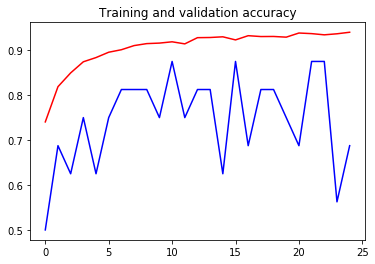

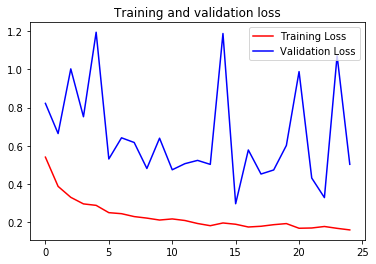

In [48]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [50]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150,3))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a Normal")
  else:
    print(fn + " is a Pneumonia")

Saving datasets_17810_23812_chest_xray_chest_xray_test_NORMAL_IM-0003-0001.jpeg to datasets_17810_23812_chest_xray_chest_xray_test_NORMAL_IM-0003-0001.jpeg
Saving datasets_17810_23812_chest_xray_chest_xray_test_NORMAL_IM-0025-0001.jpeg to datasets_17810_23812_chest_xray_chest_xray_test_NORMAL_IM-0025-0001.jpeg
Saving datasets_17810_23812_chest_xray_chest_xray_test_PNEUMONIA_person103_bacteria_488.jpeg to datasets_17810_23812_chest_xray_chest_xray_test_PNEUMONIA_person103_bacteria_488.jpeg
Saving datasets_17810_23812_chest_xray_chest_xray_test_PNEUMONIA_person109_bacteria_527.jpeg to datasets_17810_23812_chest_xray_chest_xray_test_PNEUMONIA_person109_bacteria_527.jpeg
Saving ill.jpg to ill.jpg
Saving ill1.jpg to ill1.jpg
Saving ill2.jpg to ill2.jpg
Saving ill3.jpg to ill3.jpg
[0.]
datasets_17810_23812_chest_xray_chest_xray_test_NORMAL_IM-0003-0001.jpeg is a Pneumonia
[1.]
datasets_17810_23812_chest_xray_chest_xray_test_NORMAL_IM-0025-0001.jpeg is a Normal
[1.]
datasets_17810_23812_chest

In [0]:
'''
Y_pred = model.predict_generator(test_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['NORMAL', 'PNEUMONIA']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))
'''